# LSTM-RNN

[LSTM-RNN](https://en.wikipedia.org/wiki/Long_short-term_memory) stands for long short term memory recurrent neural network. It is a deep learning architecture of neural network that utilizes feedback connections in order to "remember" past states and for this reason are well suited for time series prediction tasks.

My approach in this report is largely based off of [this post](https://www.section.io/engineering-education/stock-price-prediction-using-python/) on building an LSTM-RNN using daily Tesla closing price data. 

## Obtain data

I will use the function I [developed previously](./wrangle.html) to import NVDA stock price data and limit the date to April 29th, 2022 for reproducibility and to compare RMSE with the other models in this [report](./nvda_analysis.html).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import keras.optimizers 
from tensorflow import keras
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from python.functions import get_stonk

nvda_all = get_stonk("nvda")
nvda = nvda_all["data"]
nvda = nvda[:"2022-04-29"]
nvda

2022-05-21 06:51:48.832346: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-21 06:51:48.832367: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


,Open,High,Low,Close,Volume
Date,,,,,
1999-01-22,0.401824,0.448464,0.356379,0.376709,271468800.0
1999-01-25,0.406607,0.420958,0.376709,0.416174,51048000.0
1999-01-26,0.420958,0.429329,0.377905,0.383885,34320000.0
1999-01-27,0.385081,0.394649,0.363554,0.382690,24436800.0
1999-01-28,0.382689,0.385081,0.379101,0.381494,22752000.0
...,...,...,...,...,...
2022-04-25,192.020004,199.449997,190.960007,199.020004,64156600.0
2022-04-26,197.179993,197.880005,186.699997,187.880005,65314300.0
2022-04-27,185.979996,191.669998,182.899994,184.149994,49946000.0


## Feature engineering 

I will add in a column that takes the difference between the 26 and 12 day exponential weighted moving average (EWMA). The intent here is to capture information about which EWMA is above the other in a single vector.

I will also add a column with the day of the week and a column with the day of the year in an attempt to capture seasonality effects.

In [2]:
nvda["ewma_diff"] = nvda_all["ewma"]["26"] - nvda_all["ewma"]["12"]
nvda.index.name = "date"
nvda.reset_index(inplace=True)
nvda["weekday"] = pd.to_datetime(nvda['date'].astype(str)).dt.weekday
nvda["year_day"] = pd.to_datetime(nvda['date'].astype(str)).dt.day_of_year
nvda = nvda.set_index(["date"])
nvda

/tmp/ipykernel_124104/1207428108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvda["ewma_diff"] = nvda_all["ewma"]["26"] - nvda_all["ewma"]["12"]
/tmp/ipykernel_124104/1207428108.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvda["weekday"] = pd.to_datetime(nvda['date'].astype(str)).dt.weekday
/tmp/ipykernel_124104/1207428108.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

,Open,High,Low,Close,Volume,ewma_diff,weekday,year_day
date,,,,,,,,
1999-01-22,0.401824,0.448464,0.356379,0.376709,271468800.0,0.000000,4,22
1999-01-25,0.406607,0.420958,0.376709,0.416174,51048000.0,-0.003148,0,25
1999-01-26,0.420958,0.429329,0.377905,0.383885,34320000.0,-0.003003,1,26
1999-01-27,0.385081,0.394649,0.363554,0.382690,24436800.0,-0.002760,2,27
1999-01-28,0.382689,0.385081,0.379101,0.381494,22752000.0,-0.002442,3,28
...,...,...,...,...,...,...,...,...
2022-04-25,192.020004,199.449997,190.960007,199.020004,64156600.0,13.634018,0,115
2022-04-26,197.179993,197.880005,186.699997,187.880005,65314300.0,14.964651,1,116
2022-04-27,185.979996,191.669998,182.899994,184.149994,49946000.0,16.134183,2,117


## Split the data

I will now split the data into train/validate/test sets in a 70/20/10 percentage split respectively.

In [10]:
train = nvda[:round(len(nvda)*0.7)]
validate = nvda[round(len(nvda)*0.7)+1:round(len(nvda)*0.9)]
test = nvda[round(len(nvda)*0.9)+1:]
print(f"Train:\t\t{train.shape}\nValidate:\t{validate.shape}\nTest:\t\t{test.shape}")

Train:		(4101, 8)
Validate:	(1170, 8)
Test:		(585, 8)


## Normalization

The data must be min/max normalized in order for the neural network to appropriately interpret signal.

In [8]:
# scaler = MinMaxScaler(feature_range=(0,1))
# train = scaler.fit_transform(train)
# validate = scaler.fit_transform(validate)
# test = scaler.fit_transform(test)
train[:3]

,Open,High,Low,Close,Volume,ewma_diff,weekday,year_day
date,,,,,,,,
1999-01-22,0.401824,0.448464,0.356379,0.376709,271468800.0,0.000000,4,22
1999-01-25,0.406607,0.420958,0.376709,0.416174,51048000.0,-0.003148,0,25
1999-01-26,0.420958,0.429329,0.377905,0.383885,34320000.0,-0.003003,1,26


Great, now let's create a helper function that will build slices of our data and save the target as a vector for training.

In [90]:
scaler = MinMaxScaler(feature_range=(0,1))
def create_dataset(df, win=30, t=5, tar_col=3, scaler=scaler):
    x, x_mm, y, y_og = [], [], [], []
    for i in range(win, df.shape[0]):
        if i < df.shape[0]-t:
            x_win = np.array(df[i-win:i])
            x_norm = scaler.fit_transform(x_win)
            x.append(x_norm)
            x_min = np.amin(x_win[:,tar_col])
            x_max = np.amax(x_win[:,tar_col])
            x_mm.append((x_min, x_max))
            y_norm = df.iloc[i+t, tar_col]
            y_og.append(y_norm)
            y_norm = (y_norm - x_min) / (x_max - x_min)
            y.append(y_norm)
    x, y, y_og = np.array(x), np.array(y), np.array(y_og)
    return x, x_mm, y, y_og

Let's use this function to slice up our train, validate, and test sets.

In [91]:
x_train, x_train_mm, y_train, y_train_og = create_dataset(train)
x_validate, x_validate_mm, y_validate, y_validate_og = create_dataset(validate)
x_test, x_test_mm, y_test, y_test_og = create_dataset(test)
print(f"Train:\t\tinput {x_train.shape}\ttarget {y_train.shape}")
print(f"Validate:\tinput {x_validate.shape}\ttarget {y_validate.shape}")
print(f"Test:\t\tinput {x_test.shape}\ttarget {y_test.shape}")

Train:		input (4066, 30, 8)	target (4066,)
Validate:	input (1135, 30, 8)	target (1135,)
Test:		input (550, 30, 8)	target (550,)
[(58.948585510253906, 73.94316864013672), (58.948585510253906, 78.46349334716797), (58.948585510253906, 78.46349334716797), (58.948585510253906, 78.46349334716797), (58.948585510253906, 78.46349334716797), (58.948585510253906, 78.46349334716797), (58.948585510253906, 78.46349334716797), (58.948585510253906, 78.46349334716797), (58.948585510253906, 78.46349334716797), (58.948585510253906, 78.46349334716797), (58.948585510253906, 78.46349334716797), (58.948585510253906, 78.46349334716797), (58.948585510253906, 78.46349334716797), (58.948585510253906, 78.46349334716797), (58.948585510253906, 78.46349334716797), (58.948585510253906, 78.46349334716797), (58.948585510253906, 78.46349334716797), (53.9643669128418, 78.46349334716797), (53.9643669128418, 78.46349334716797), (48.99728012084961, 78.46349334716797), (48.99728012084961, 78.46349334716797), (48.997280120849

From the ouput above it looks like we have the data in the correct shape for the LSTM model to ingest.

## Build the LSTM-RNN model

We will now build the model. This model will be composed of four LSTM layers, each followed by a 20% dropout layer to reduce complexity between layers and help prevent overfitting. The output neuron is a single dense layer since we are just trying to predict the single closing price five days later.

The model will use MSE as its loss function, [Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) as its optimization function, and will use the default learning rate of 0.01.

But first I will set random seeds so that my LSTM experiments are reproducible. My approach is based off of this [link](https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752).

In [47]:
# Set a seed value
seed_value= 12321 

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

# 5. For layers that introduce randomness like dropout, make sure to set seed values 

#6 Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

2022-05-21 07:34:49.372097: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-21 07:34:49.376785: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-21 07:34:49.376889: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-21 07:34:49.376936: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (myPotato): /proc/driver/nvidia/version does not exist


Now let's compile the model.

In [48]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], nvda.shape[1])))
model.add(Dropout(0.2, seed=seed_value))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2, seed=seed_value))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2, seed=seed_value))
model.add(LSTM(units=96))
model.add(Dropout(0.2, seed=seed_value))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')
model

With the model now compiled we can fit the model on our training data. I will train for 30 epochs using a [batch size](https://deeplizard.com/learn/video/U4WB9p6ODjM) of 32. I will set shuffle to false as we do not want to shuffle the data because we should maintain the sequential nature of the data.

In [49]:
fit = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_validate, y_validate), shuffle=False)
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(fit.history['loss'], label='train')
plt.plot(fit.history['val_loss'], label='validate')
plt.legend()
plt.show()
model.save("./lstm_models/nvda_adam_e30_b32.h5")

Epoch 1/30
128/128 [==============================] - 14s 73ms/step - loss: 5.3367e-04 - val_loss: 1.3842e-07
Epoch 2/30
128/128 [==============================] - 8s 64ms/step - loss: 1.3375e-05 - val_loss: 5.5548e-07
Epoch 3/30
128/128 [==============================] - 8s 65ms/step - loss: 8.8364e-06 - val_loss: 1.2413e-07
Epoch 4/30
128/128 [==============================] - 9s 70ms/step - loss: 6.7160e-06 - val_loss: 6.7604e-08
Epoch 5/30
128/128 [==============================] - 9s 74ms/step - loss: 5.5652e-06 - val_loss: 2.2816e-07
Epoch 6/30
128/128 [==============================] - 9s 73ms/step - loss: 5.0554e-06 - val_loss: 4.9159e-08
Epoch 7/30
128/128 [==============================] - 9s 73ms/step - loss: 4.2186e-06 - val_loss: 1.9267e-07
Epoch 8/30
128/128 [==============================] - 9s 73ms/step - loss: 3.8342e-06 - val_loss: 6.8420e-07
Epoch 9/30
128/128 [==============================] - 9s 73ms/step - loss: 3.4384e-06 - val_loss: 1.1735e-06
Epoch 10/30
128/12

The loss seems to have stabilized well during training. Now that the model is fit let's make some predictions on the validate set and plot them against the actual price.

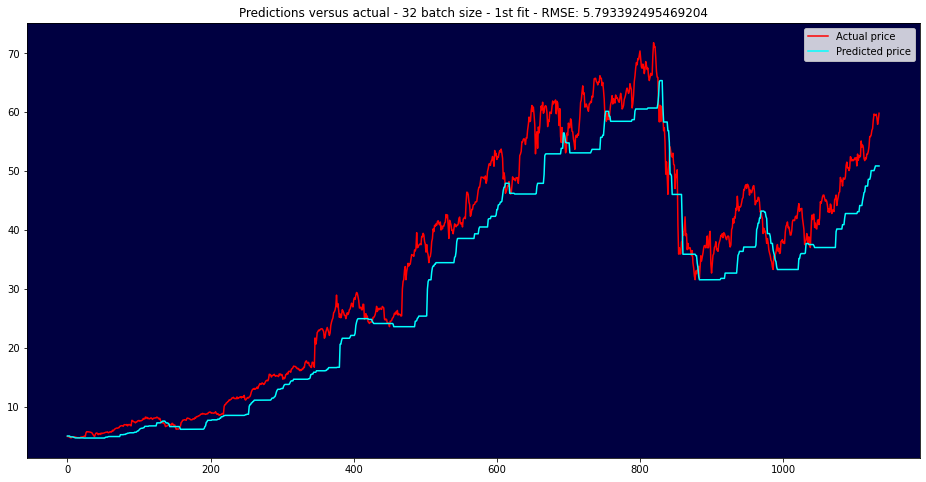

In [102]:
model = load_model("./lstm_models/nvda_adam_e30_b32.h5")

predictions = model.predict(x_validate)

def inverse_preds(preds, x_mm):
    preds = preds.reshape(-1)
    preds_inv = []
    for i in range(len(preds)):
        preds_inv.append((preds[i] * (x_mm[i][1]-x_mm[i][0]))+x_mm[i][0])
    return np.array(preds_inv)
    
predictions = inverse_preds(predictions, x_validate_mm)

rmse = mean_squared_error(y_validate_og, predictions, squared=False)

def plot_preds(preds, og, rmse, title):
    fig, ax = plt.subplots(figsize=(16,8))
    ax.set_facecolor('#000041')
    ax.plot(y_validate_og, color='red', label='Actual price')
    plt.plot(predictions, color='cyan', label='Predicted price')
    plt.title(f"Predictions versus actual - 32 batch size - 1st fit - RMSE: {rmse}")
    plt.legend()
    plt.show()

title_ = f"Predictions versus actual - 32 batch size - 1st fit - RMSE: {rmse}"
plot_preds(predictions, y_validate_og, rmse, title_)

It looks like our first pass at fitting our model did pretty well. It sometime tracks the actual price but also does dramatically diverge at times.

In order to diagnose how our model fit is I will make a plot showing training loss versus validation loss. See this [link](https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/) for more about these plots.

This is pretty good looking plot as the training loss stays below the validation and both decay over time less.

Let's fit another but I will increase the batch size to 64.

Epoch 1/30
64/64 [==============================] - 13s 139ms/step - loss: 0.3458 - val_loss: 0.3515
Epoch 2/30
64/64 [==============================] - 6s 95ms/step - loss: 0.2664 - val_loss: 0.2907
Epoch 3/30
64/64 [==============================] - 6s 99ms/step - loss: 0.2275 - val_loss: 0.2803
Epoch 4/30
64/64 [==============================] - 7s 102ms/step - loss: 0.2114 - val_loss: 0.2615
Epoch 5/30
64/64 [==============================] - 7s 104ms/step - loss: 0.2048 - val_loss: 0.2509
Epoch 6/30
64/64 [==============================] - 7s 111ms/step - loss: 0.2007 - val_loss: 0.2507
Epoch 7/30
64/64 [==============================] - 8s 123ms/step - loss: 0.1965 - val_loss: 0.2471
Epoch 8/30
64/64 [==============================] - 7s 103ms/step - loss: 0.1956 - val_loss: 0.2505
Epoch 9/30
64/64 [==============================] - 8s 122ms/step - loss: 0.1930 - val_loss: 0.2496
Epoch 10/30
64/64 [==============================] - 8s 120ms/step - loss: 0.1946 - val_loss: 0.2491


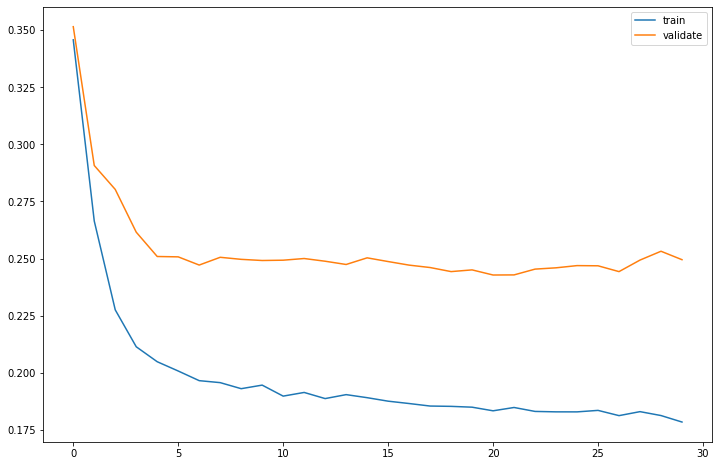

In [97]:
fit = model.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_validate, y_validate), shuffle=False)
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(fit.history['loss'], label='train')
plt.plot(fit.history['val_loss'], label='validate')
plt.legend()
plt.show()
model.save("./lstm_models/nvda_adam_e30_b64.h5")

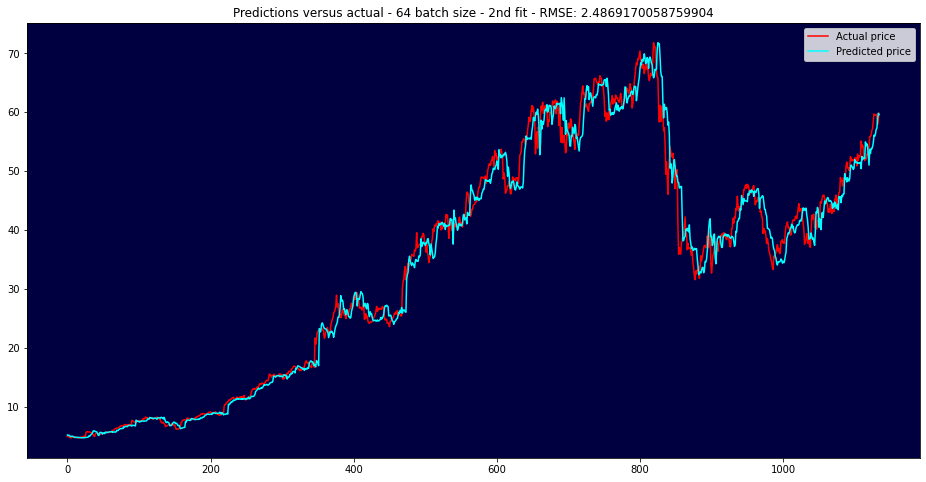

In [99]:
model = load_model("./lstm_models/nvda_adam_e30_b64.h5")

predictions = inverse_preds(model.predict(x_validate), x_validate_mm)

rmse = mean_squared_error(y_validate_og, predictions, squared=False)

fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor('#000041')
ax.plot(y_validate_og, color='red', label='Actual price')
plt.plot(predictions, color='cyan', label='Predicted price')
plt.title(f"Predictions versus actual - 64 batch size - 2nd fit - RMSE: {rmse}")
plt.legend()

Epoch 1/30
64/64 [==============================] - 13s 117ms/step - loss: 0.3578 - val_loss: 0.3271
Epoch 2/30
64/64 [==============================] - 6s 88ms/step - loss: 0.2862 - val_loss: 0.3146
Epoch 3/30
64/64 [==============================] - 5s 85ms/step - loss: 0.2785 - val_loss: 0.3098
Epoch 4/30
64/64 [==============================] - 6s 86ms/step - loss: 0.2722 - val_loss: 0.3077
Epoch 5/30
64/64 [==============================] - 6s 92ms/step - loss: 0.2686 - val_loss: 0.3037
Epoch 6/30
64/64 [==============================] - 6s 101ms/step - loss: 0.2661 - val_loss: 0.3029
Epoch 7/30
64/64 [==============================] - 6s 99ms/step - loss: 0.2635 - val_loss: 0.2974
Epoch 8/30
64/64 [==============================] - 6s 101ms/step - loss: 0.2601 - val_loss: 0.2977
Epoch 9/30
64/64 [==============================] - 6s 99ms/step - loss: 0.2579 - val_loss: 0.2965
Epoch 10/30
64/64 [==============================] - 7s 102ms/step - loss: 0.2551 - val_loss: 0.2959
Epoc

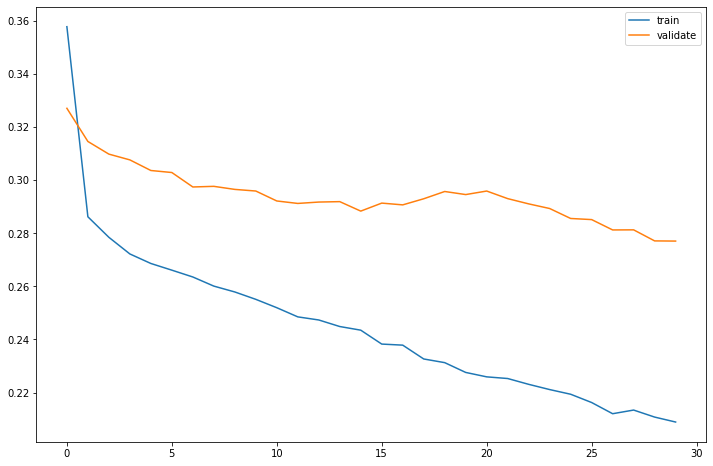

In [100]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], nvda.shape[1])))
model.add(Dropout(0.2, seed=seed_value))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2, seed=seed_value))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2, seed=seed_value))
model.add(LSTM(units=96))
model.add(Dropout(0.2, seed=seed_value))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adamax())

fit = model.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_validate, y_validate), shuffle=False)
model.save("./lstm_models/nvda_adamax_e30_b64.h5")

fig, ax = plt.subplots(figsize=(12,8))
plt.plot(fit.history['loss'], label='train')
plt.plot(fit.history['val_loss'], label='validate')
plt.legend()
plt.show()

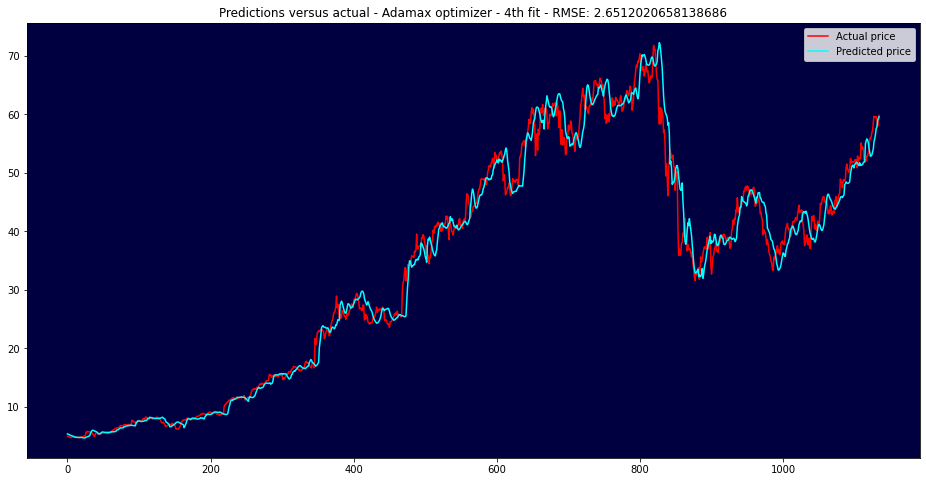

In [103]:
model = load_model("./lstm_models/nvda_adamax_e30_b64.h5")

predictions = inverse_preds(model.predict(x_validate), x_validate_mm)

rmse = mean_squared_error(y_validate_og, predictions, squared=False)

fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor('#000041')
ax.plot(y_validate_og, color='red', label='Actual price')
plt.plot(predictions, color='cyan', label='Predicted price')
plt.title(f"Predictions versus actual - Adamax optimizer - 4th fit - RMSE: {rmse}")
plt.legend()

This is a pretty good fit with low RMSE and we don't see as much random divergence from the actual price. 

This loss comparison plot is troublesome however. Seeing as the train loss dips below the validation loss we might have a case of overfitting.

Let's explore whether I am experiencing the curse of dimensionality by reducing the number of features in the model to only those I think are the most descriptive.

In [49]:
nvda_less = nvda[["Close", "ewma_diff", "year_day"]]

train = nvda_less[:round(len(nvda_less)*0.7)]
validate = nvda_less[round(len(nvda)*0.7)+1:round(len(nvda_less)*0.9)]
test = nvda_less[round(len(nvda_less)*0.9)+1:]

# scaler = MinMaxScaler(feature_range=(0,1))
# train = scaler.fit_transform(train)
# validate = scaler.fit_transform(validate)
# test = scaler.fit_transform(test)

x_train, y_train = create_dataset(train, tar_col=0)
x_validate, y_validate = create_dataset(validate, tar_col=0)
x_test, y_test = create_dataset(test, tar_col=0)
print(f"Train:\t\tinput {x_train.shape}\ttarget {y_train.shape}")
print(f"Validate:\tinput {x_validate.shape}\ttarget {y_validate.shape}")
print(f"Test:\t\tinput {x_test.shape}\ttarget {y_test.shape}")

InvalidIndexError: (slice(0, 30, None), slice(None, None, None))

With fewer features we will hopefully not over fit to the data as much. I will also progressively increase the dropout rate in each LSTM layer as another way to hopefully prevent over fitting.

In [24]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], nvda_less.shape[1])))
model.add(Dropout(0.2, seed=seed_value))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.3, seed=seed_value))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.4, seed=seed_value))
model.add(LSTM(units=96))
model.add(Dropout(0.5, seed=seed_value))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adamax())

fifth_fit = model.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_validate, y_validate), shuffle=False)
model.save("./lstm_models/nvda_less_adamax_e30_b64.h5")

Epoch 1/30
64/64 [==============================] - 18s 167ms/step - loss: 0.0455 - val_loss: 0.0295
Epoch 2/30
33/64 [==============>...............] - ETA: 5s - loss: 0.0109

KeyboardInterrupt: 

In [ ]:
model = load_model("./lstm_models/nvda_less_adamax_e30_b64.h5")
predictions = model.predict(x_validate)
validate_pred_2d = np.zeros(shape=(len(predictions), nvda_less.shape[1]))
validate_pred_2d[:,0] = predictions[:,0]
predictions = scaler.inverse_transform(validate_pred_2d)[:,0]

y_validate_2d = np.zeros(shape=(len(y_validate), nvda_less.shape[1]))
y_validate_2d[:,0] = y_validate
y_validate_scaled = scaler.inverse_transform(y_validate_2d)[:,0]

rmse = mean_squared_error(y_validate_scaled, predictions, squared=False)

fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor('#000041')
ax.plot(y_validate_scaled, color='red', label='Actual price')
plt.plot(predictions, color='cyan', label='Predicted price')
plt.title(f"Predictions versus actual - less data - 5th fit - RMSE: {rmse}")
plt.legend()

It looks like the fit has improved by using less features.

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(fifth_fit.history['loss'], label='train')
plt.plot(fifth_fit.history['val_loss'], label='validate')
plt.legend()
plt.show()

The training loss dips below the validate loss briefly which is not optimal as it could indicate overfitting.

I will fit one more model using 500 epochs but employ [early stopping](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/) to exit training when model performance stops improving. This is another method to help reduce overfitting.

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)

sixth_fit = model.fit(x_train, y_train, epochs=500, batch_size=64, validation_data=(x_validate, y_validate), shuffle=False, callbacks=[es])
model.save("./lstm_models/nvda_less_adamax_ES_b64.h5")

In [ ]:
model = load_model("./lstm_models/nvda_less_adamax_ES_b64.h5")
predictions = model.predict(x_validate)
validate_pred_2d = np.zeros(shape=(len(predictions), nvda_less.shape[1]))
validate_pred_2d[:,0] = predictions[:,0]
predictions = scaler.inverse_transform(validate_pred_2d)[:,0]

y_validate_2d = np.zeros(shape=(len(y_validate), nvda_less.shape[1]))
y_validate_2d[:,0] = y_validate
y_validate_scaled = scaler.inverse_transform(y_validate_2d)[:,0]

rmse = mean_squared_error(y_validate_scaled, predictions, squared=False)

fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor('#000041')
ax.plot(y_validate_scaled, color='red', label='Actual price')
plt.plot(predictions, color='cyan', label='Predicted price')
plt.title(f"Predictions versus actual - less data & early stop - 6th fit - RMSE: {rmse}")
plt.legend()

These fit improves when early stopping is applied.

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(sixth_fit.history['loss'], label='train')
plt.plot(sixth_fit.history['val_loss'], label='validate')
plt.legend()
plt.show()

The loss plot jumps around and the training loss does dip below validation loss.

Let's end the analysis by building an ensemble model.

In [ ]:
def ensemble_lstm(data):
    predictions = list()
    nvda_less_adamax_ES_b32 = load_model("./lstm_models/nvda_less_adamax_ES_b64.h5")
    nvda_less_adamax_e30_b64 = load_model("./lstm_models/nvda_less_adamax_e30_b64.h5")
    models = [nvda_less_adamax_ES_b32, nvda_less_adamax_e30_b64]
    for model in models:
        pred = model.predict(data)
        pred_2d = np.zeros(shape=(len(pred), nvda_less.shape[1]))
        pred_2d[:,0] = pred[:,0]
        predictions.append(scaler.inverse_transform(pred_2d)[:,0])

    return sum(predictions) / len(predictions)

preds = ensemble_lstm(x_validate)

rmse = mean_squared_error(y_validate_scaled, preds, squared=False)

fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor('#000041')
ax.plot(y_validate_scaled, color='red', label='Actual price')
plt.plot(preds, color='cyan', label='Predicted price')
plt.title(f"Comparing predictions to actual - ensemble - RMSE: {rmse}")
plt.legend()

I will use this ensemble of LSTM models in my final ensemble model which I analyze in the [Nvidia analysis](./nvda_analysis.html) report.

## Conclusion

I think that this model does not perform well enough to be confident using it effectively in any options trading strategy. With more time it could perhaps be incrementally improved upon but I would guess that taking a step back and re-examining the problem to approach it from a different angle might be better. Perhaps I could add in other features that provide other insight for the model and/or change the model architecture to be more appropriate.